<a href="https://colab.research.google.com/github/yiruchen1993/1st-DL-CVMarathon/blob/feature%2Ffinal_project/D50_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [3]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [5]:
import os
# 此處為google drive中的文件路徑，drive為之前指定的工作跟目錄，要加上位置
# 如果存放的路徑有變，從/content/drive/My Drive/XXXXX...做調整
path = "/content/drive/My Drive/study/DL_CV/Final_Project"
os.chdir(path)
!git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

Cloning into 'keras-yolo3'...
remote: Enumerating objects: 144, done.
remote: Total 144 (delta 0), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (144/144), 151.07 KiB | 5.59 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/drive/My Drive/study/DL_CV/Final_Project/keras-yolo3


In [6]:
import os
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model doesn't exist, downloading...
Converting yolov3.weights to yolo.h5...


In [8]:
# 直接下載 VOC2007 的資料集作為範例
if not os.path.exists("VOCdevkit"):
  os.system("wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar") # 下載 VOC 資料集
  os.system("tar xvf VOCtrainval_06-Nov-2007.tar") # 解壓縮資料集，會花幾分鐘
else:
  print("data exists")

data exists


In [9]:
if not os.path.exists("2007_train.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
  import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
  from os import getcwd

  sets=[('2007', 'train'), ('2007', 'val')]

  # Pascal VOC 的資料類別
  classes = ["raccoon", "kangaroo"]

  # 把 annotation 轉換訓練時需要的資料形態
  def convert_annotation(year, image_id, list_file):
      in_file = open('VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id))
      tree=ET.parse(in_file)
      root = tree.getroot()

      for obj in root.iter('object'):
          difficult = obj.find('difficult').text
          cls = obj.find('name').text
          if cls not in classes or int(difficult)==1:
              continue
          cls_id = classes.index(cls)
          xmlbox = obj.find('bndbox')
          b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
          list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

  wd = "."

  for year, image_set in sets:
      image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
      annotation_path = '%s_%s.txt'%(year, image_set)
      list_file = open(annotation_path, 'w')
      print("save annotation at %s" % annotation_path)
      for image_id in image_ids[:1000]: # 只處理 100 張圖片來做範例
          list_file.write('%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg'%(wd, year, image_id))
          convert_annotation(year, image_id, list_file)
          list_file.write('\n')
      list_file.close()

save annotation at 2007_train.txt
save annotation at 2007_val.txt


In [10]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


In [11]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [12]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Converting pretrained YOLOv3 weights for training


In [18]:
if not os.path.exists("raccoon_dataset"):
    !git clone https://github.com/experiencor/raccoon_dataset.git  
else:
    print("raccoon_dataset exists")

raccoon_dataset exists


In [17]:
if not os.path.exists("kangaroo"):
    !git clone https://github.com/experiencor/kangaroo.git  
else:
    print("kangaroo exists")

kangaroo exists


In [16]:
os.getcwd()

'/content/drive/My Drive/study/DL_CV/Final_Project/keras-yolo3'

In [47]:
# 把 raccoon_dataset/images 與 kangaroo/images 檔案合併後, 
# 當成訓練集 & 驗證集 & 測試集資料
for root, dirs, files in os.walk('raccoon_dataset/images'):
    print('num of raccoon jpg:', len(files))

for root, dirs, files2 in os.walk('kangaroo/images'):
    print('num of kangaroo jpg:', len(files2))

# combine raccoon and kangaroo data
files.extend(files2)
print(len(files))

jpg_ids = ''.join(files).strip().split('.jpg')[:-1]
print(jpg_ids)

num of raccoon jpg: 200
num of kangaroo jpg: 164
364
['raccoon-1', 'raccoon-10', 'raccoon-100', 'raccoon-101', 'raccoon-102', 'raccoon-103', 'raccoon-104', 'raccoon-105', 'raccoon-106', 'raccoon-107', 'raccoon-108', 'raccoon-109', 'raccoon-11', 'raccoon-110', 'raccoon-111', 'raccoon-112', 'raccoon-113', 'raccoon-114', 'raccoon-115', 'raccoon-116', 'raccoon-117', 'raccoon-118', 'raccoon-119', 'raccoon-12', 'raccoon-120', 'raccoon-121', 'raccoon-122', 'raccoon-123', 'raccoon-124', 'raccoon-125', 'raccoon-126', 'raccoon-127', 'raccoon-128', 'raccoon-129', 'raccoon-13', 'raccoon-130', 'raccoon-131', 'raccoon-132', 'raccoon-133', 'raccoon-134', 'raccoon-135', 'raccoon-136', 'raccoon-137', 'raccoon-138', 'raccoon-139', 'raccoon-14', 'raccoon-140', 'raccoon-141', 'raccoon-142', 'raccoon-143', 'raccoon-144', 'raccoon-145', 'raccoon-146', 'raccoon-147', 'raccoon-148', 'raccoon-149', 'raccoon-15', 'raccoon-150', 'raccoon-151', 'raccoon-152', 'raccoon-153', 'raccoon-154', 'raccoon-155', 'raccoon-

In [54]:
sets = ['train', 'val', 'test']
# "raccoon", "kangaroo" 的資料類別
classes = ["raccoon", "kangaroo"]

In [49]:
# print(len(jpg_ids))
np.random.seed(0)
train_index = np.random.choice(jpg_ids, size=int(len(jpg_ids)*0.7), replace=False)
# print(len(train_index))

non_train = np.setdiff1d(jpg_ids, train_index)
# print(len(non_train))

val_index = np.random.choice(non_train, size=int(len(non_train)*0.7), replace=False)
# print(len(val_index))
test_index = np.setdiff1d(test, val_index)
# print(len(test_index))

364
254
110
77
14


In [50]:
!mkdir train val test
# train index
train_txt = open('train/train.txt', 'w')
print("save train index at train/train.txt")       
for train_id in train_index : 
    train_txt.write('%s' %(train_id))
    train_txt.write('\n')
train_txt.close()

# val index
val_txt = open('val/val.txt', 'w')
print("save val index at val/val.txt")       
for val_id in val_index : 
    val_txt.write('%s' %(val_id))
    val_txt.write('\n')
val_txt.close()

# test index
test_txt = open('test/test.txt', 'w')
print("save test index at test/test.txt")       
for test_id in test_index : 
    test_txt.write('%s' %(test_id))
    test_txt.write('\n')
test_txt.close()

save train index at train/train.txt
save val index at val/val.txt
save test index at test/test.txt


In [51]:
# save annotation xml
!mkdir annotation_xml
!cp raccoon_dataset/annotations/*.xml ./annotation_xml
!cp kangaroo/annots/*.xml ./annotation_xml

In [69]:
# save class
class_txt = open('class.txt', 'w')
      
for class_id in classes : 
    class_txt.write('%s' %(class_id))
    class_txt.write('\n')
class_txt.close()

In [67]:
import xml.etree.ElementTree as ET

# transform data format
def convert_annotation(image_id, list_file):
    in_file = open('annotation_xml/%s.xml'%(image_id))
    tree = ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1: 
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), 
             int(xmlbox.find('ymin').text), 
             int(xmlbox.find('xmax').text),
             int(xmlbox.find('ymax').text))
        list_file_str = " " + ",".join([str(a) for a in b]) + ',' + str(cls_id)
        list_file.write(list_file_str)

In [68]:
for image_set in sets:
    image_ids = open('%s/%s.txt'%(image_set, image_set)).read().strip().split()
    annotation_path = '%s_labels.txt'%(image_set)
    list_file = open(annotation_path, 'w')
    print("save annotation at %s" % annotation_path)
    # transform data format
    for image_id in image_ids:
      if 'raccoon' in image_id:
        list_file.write('./raccoon_dataset/images/%s.jpg' %(image_id))
      else:
        list_file.write('./kangaroo/images/%s.jpg' %(image_id))  
      convert_annotation(image_id, list_file)
      list_file.write('\n')
    list_file.close()

save annotation at train_labels.txt
save annotation at val_labels.txt
save annotation at test_labels.txt


In [72]:
annotation_path = 'train_labels.txt' # 轉換好格式的標註檔案
val_annotation_path = 'val_labels.txt' 
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'class.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416, 416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
num_val = len(val_index)
num_train = len(train_index)

with open(annotation_path) as f:
    lines_train = f.readlines()

with open(val_annotation_path) as f:
    lines_val = f.readlines()















Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [84]:
# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    md = model.fit_generator(data_generator_wrapper(lines_train, batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines_val, batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            # callbacks=[checkpoint])
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

Train on 254 samples, val on 77 samples, with batch size 16.
Epoch 1/5
15/15 [==============================] - 43s 3s/step - loss: 26.7327 - val_loss: 86.0949
Epoch 2/5
15/15 [==============================] - 19s 1s/step - loss: 25.7935 - val_loss: 2673.9424
Epoch 3/5
15/15 [==============================] - 24s 2s/step - loss: 31.1281 - val_loss: 2210931.3845
Epoch 4/5
15/15 [==============================] - 24s 2s/step - loss: 45.4401 - val_loss: 25845413.0000
Epoch 5/5
15/15 [==============================] - 24s 2s/step - loss: 29.4595 - val_loss: 384851.7109


In [76]:
# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines_train, batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines_val, batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=10,
        initial_epoch=51,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Unfreeze all of the layers.
Train on 254 samples, val on 77 samples, with batch size 16.


In [88]:
from PIL import Image
image = Image.open('data_test/rac_2.jpg')

In [89]:
#進行圖片測試
from yolo import YOLO
yolo_model = YOLO(model_path='logs/000/trained_weights_final.h5', classes_path=classes_path)

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.


In [90]:
r_image = yolo_model.detect_image(image)

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (412, 0) (2481, 1547)
3.876781607999874


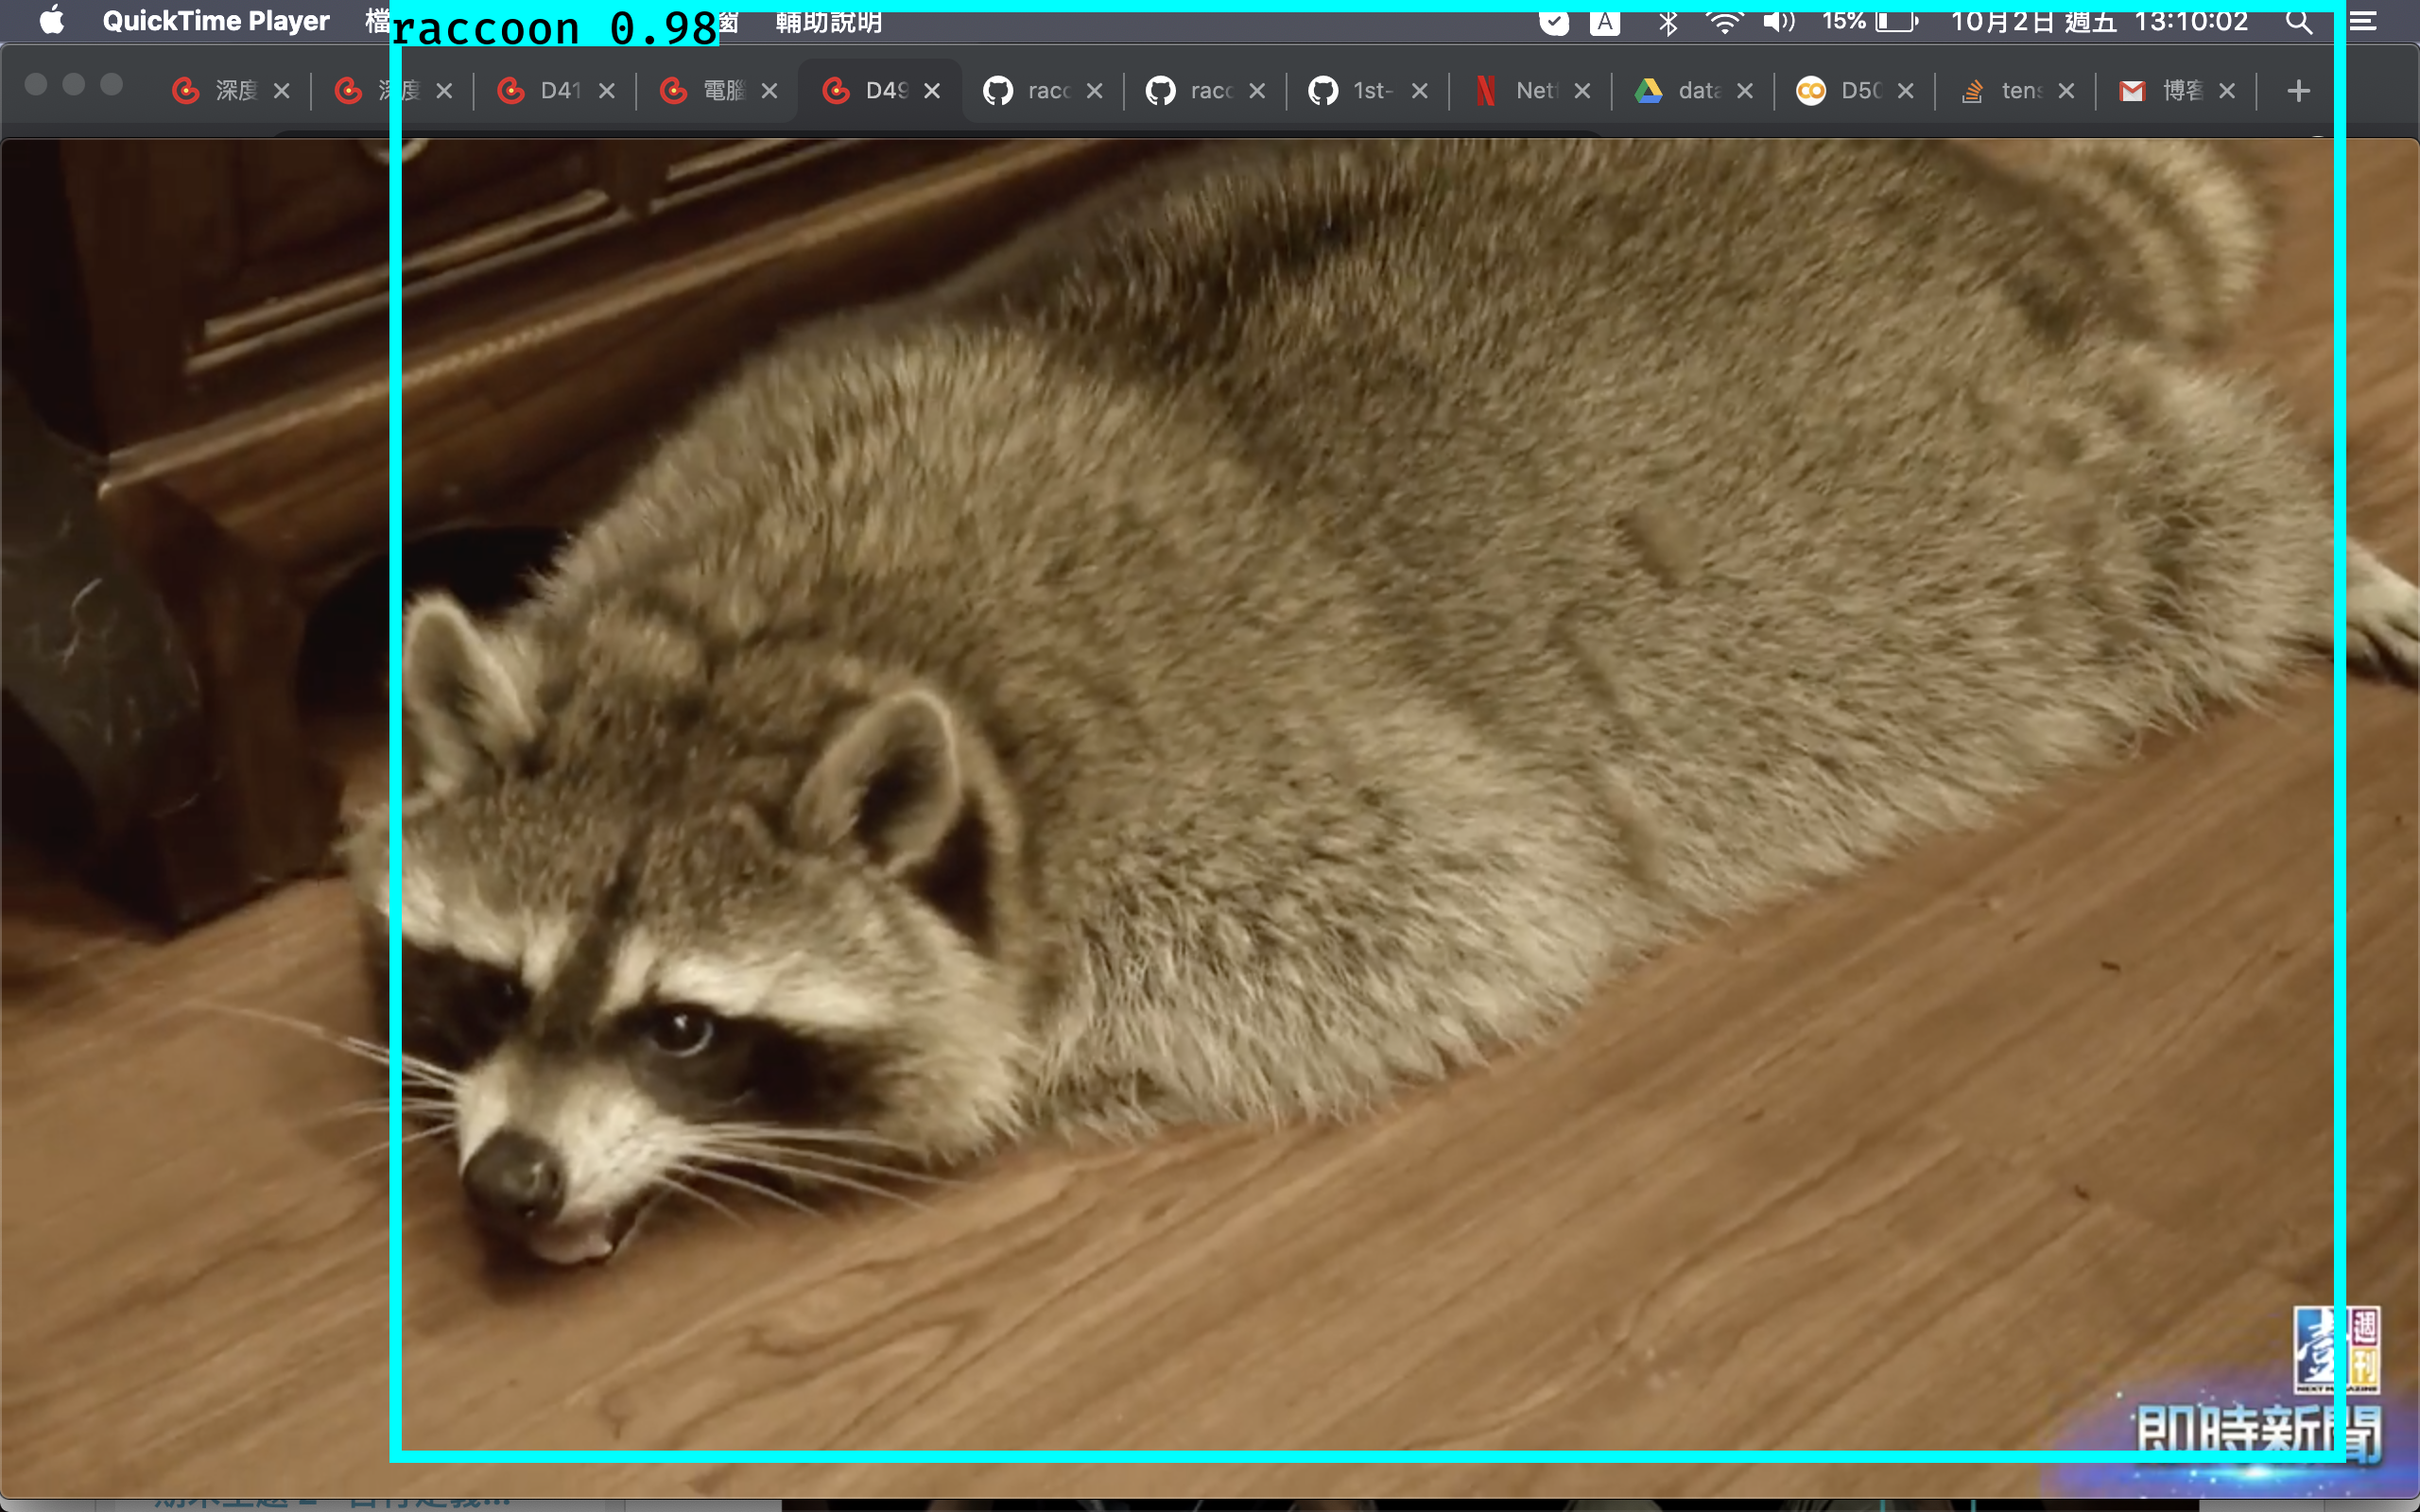

In [91]:
r_image